In [1]:
# System libraries
import sys, os, gc
import datetime

# Math libraries
import math, random
import pandas as pd, numpy as np
import scipy
from scipy import stats
from datetime import timedelta
from datetime import datetime
import itertools

# Data storage libraries
import pickle, sqlite3, simpledbf, boto3

# Custom financial data libraries
import findata_utils as fd
import ml_utils

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")

from importlib import reload
fd = reload(fd)

import sklearn as sk
import tensorflow as tf
import xgboost as xgb
import keras

from imblearn.over_sampling import RandomOverSampler

from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib 

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from yellowbrick.regressor import ResidualsPlot, PredictionError

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
overleaf = ['C:','Users','bryce','OneDrive','Documents','Overleaf','5babbfe264c952737a9a5117','esc499']
conn = sqlite3.connect(db)
c = conn.cursor()

hdf_path = 'C:\\Datasets\\thesis.h5'
hdf = pd.HDFStore(hdf_path)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Construct the index market cap

In [2]:
limit = 0.5

index_mkt_cap = pd.read_sql('''SELECT * FROM index_mkt_cap_bbgmethod''', conn)
index_mkt_cap.columns = ['date','price','pct_day0','SPTSXComp']
#index_mkt_cap['threshold'] = index_mkt_cap['SPTSXComp']*0.0004
#index_mkt_cap['lower'] = index_mkt_cap['threshold']*(1-limit)
#index_mkt_cap['upper'] = index_mkt_cap['threshold']*(1+limit)

index_mkt_cap['datetime'] = index_mkt_cap['date'].apply(lambda date: datetime.strptime(str(date)[:10], '%Y-%m-%d'))
index_mkt_cap['month'] = index_mkt_cap['datetime'].apply(lambda date: date.strftime('%Y-%m'))
index_mkt_cap['date'] = index_mkt_cap['datetime'].apply(lambda date: date.strftime('%Y-%m-%d'))
index_mkt_cap['is_ranking_week'] = index_mkt_cap['datetime'].apply(lambda date: (date+timedelta(days=14)).month!=date.month)

index_mkt_cap.drop(['datetime'],axis=1, inplace=True)

display(index_mkt_cap.head())

avg_mkt_caps = pd.DataFrame(index_mkt_cap.loc[index_mkt_cap['is_ranking_week']].groupby(by=['month'])['SPTSXComp'].mean()).reset_index()
display(avg_mkt_caps.head())

,date,price,pct_day0,SPTSXComp,month,is_ranking_week
0,2018-12-31,14322.86,0.879905,7.425816e+11,2018-12,True
1,2018-12-28,14222.00,0.873709,7.373524e+11,2018-12,True
2,2018-12-27,14165.21,0.870220,7.344081e+11,2018-12,True
3,2018-12-24,13780.19,0.846567,7.144464e+11,2018-12,True
4,2018-12-21,13935.44,0.856105,7.224955e+11,2018-12,True


,month,SPTSXComp
0,1999-03,3.413876e+11
1,1999-04,3.640760e+11
2,1999-05,3.562301e+11
3,1999-06,3.605815e+11
4,1999-07,3.679413e+11


## Look at marginal securities only

In [310]:
index_changes = pd.read_sql('''
    SELECT date, action, ticker,
        SUBSTR(date,0,8) AS month
    FROM factset_index_changes
    WHERE [index] IN ('{StudyIndex}')
    '''.format(StudyIndex='S&P/TSX Composite Index'), conn)

index_changes['ranking_month'] = index_changes['month'].apply(lambda month: (datetime.strptime(month, '%Y-%m')-timedelta(days=28)).strftime('%Y-%m'))
#tickers = index_changes['ticker'].unique()

px_cfmrc = pd.read_sql('''
    SELECT c.date, c.ticker, c.c, c.vol--, s.shares_out, c.c*s.shares_out AS mkt_cap
    FROM cfmrc c
    --WHERE mkt_cap>{MinMktCap}*0.75
        --AND c.ticker IN ('{Tickers}')
    '''.format(Tickers='', MinMktCap='')
    , conn)

so = pd.read_sql('''
    SELECT so.ticker, so.shares_out, so.float
    FROM shares_out so
    --WHERE mkt_cap>{MinMktCap}*0.75
    --WHERE c.ticker IN ('{Tickers}')
    '''.format(Tickers='', MinMktCap=''),
                 conn)

display(index_changes.head())
display(px_cfmrc.head())
display(so.head())

,date,action,ticker,month,ranking_month
0,2019-03-18 00:00:00,Add,SMU.UN,2019-03,2019-02
1,2019-03-18 00:00:00,Add,CJT,2019-03,2019-02
2,2019-03-18 00:00:00,Add,DIR.UN,2019-03,2019-02
3,2019-03-18 00:00:00,Add,AFN,2019-03,2019-02
4,2019-03-18 00:00:00,Add,NWH.UN,2019-03,2019-02


,date,ticker,c,vol
0,2011-09-13,AAA,1.19,1307785
1,2011-09-14,AAA,1.15,965285
2,2011-09-15,AAA,1.11,2612506
3,2011-09-16,AAA,1.13,857318
4,2011-09-19,AAA,1.12,477393


,ticker,shares_out,float
0,VNP,84609792.0,81319696.0
1,AW.U,12504673.0,12053858.0
2,AAB,96052280.0,62905780.0
3,ABT,40634096.0,36266072.0
4,ADN,16688416.0,8906954.0


### Deal with ticker changes

In [311]:
ticker_changes = pd.read_sql('''
    SELECT * FROM ticker_changes
    WHERE date>'{cfmrc_date}'
    '''.format(cfmrc_date=px_cfmrc.date.max())
    , conn)[['from','to']]

#print(ticker_changes.head())

for i, change in ticker_changes.iterrows():
    px_cfmrc['ticker'].replace(change['from'],change['to'], inplace=True)
    
#print(px_cfmrc.head())

px = px_cfmrc.merge(so, on=['ticker'], how='inner')

# Deal with nonsense
px['c'] = px['c'].apply(lambda c: float(c))
px['shares_out'] = px['shares_out'].replace(' ',0)
px['shares_out'] = px['shares_out'].apply(lambda so: float(so))

#print(px.head())
px['mkt_cap'] = px['shares_out']*px['c']
print(px.head())

         date ticker      c     vol  shares_out       float     mkt_cap
0  2010-01-04    AAB  0.445  743200  96052280.0  62905780.0  42743264.6
1  2010-01-05    AAB  0.430  437880  96052280.0  62905780.0  41302480.4
2  2010-01-06    AAB  0.435  360450  96052280.0  62905780.0  41782741.8
3  2010-01-07    AAB  0.445  564231  96052280.0  62905780.0  42743264.6
4  2010-01-08    AAB  0.460  889150  96052280.0  62905780.0  44184048.8


### Construct a sample of marginal securities

In [312]:
# Do not look at securities already in the index
indexed = pd.read_sql('SELECT * FROM in_the_comp', conn).set_index(['date']).unstack().reset_index()
indexed.columns = ['ticker','date','indexed']
indexed['indexed'] = indexed['indexed'].replace(1,True).replace(0,False)
indexed['month'] = indexed['date'].apply(lambda date: date[:7])

# Aggregated indexing per month
#indexed = indexed.merge(index_changes, on=['ticker','month'])#
#indexed = indexed.drop(['date_x','date_y'],axis=1)
indexed = indexed.drop_duplicates().groupby(by=['ticker','month'])
indexed = indexed['indexed'].max().reset_index()#.drop(['action'],axis=1)

display(indexed.head())

,ticker,month,indexed
0,AAV,2010-01,True
1,AAV,2010-02,True
2,AAV,2010-03,True
3,AAV,2010-04,True
4,AAV,2010-05,True


In [318]:
sample = px.copy(deep=True)
sample['datetime'] = sample['date'].apply(lambda date: datetime.strptime(str(date)[:10], '%Y-%m-%d'))
sample['is_ranking_week'] = sample['datetime'].apply(lambda date: (date+timedelta(days=14)).month!=date.month)
sample['month'] = sample['date'].apply(lambda date: str(date)[:7])

# Only look at the ranking week
sample = sample.loc[sample['is_ranking_week']]

sample = sample.merge(index_mkt_cap, on=['date'], how='inner', suffixes=('','_idc'))
sample.drop(['datetime','price','pct_day0','month_idc','is_ranking_week_idc'], axis=1, inplace=True)

display(sample.head())

sample['mkt_cap_X_vol'] = sample['mkt_cap']*sample['vol']
sample['c_X_vol'] = sample['c']*sample['vol']

grouped = sample.groupby(by=['ticker','month'])[['vol','mkt_cap_X_vol', 'c_X_vol']].sum().reset_index()
grouped['VWMC'] = grouped['mkt_cap_X_vol']/grouped['vol']
grouped['VWAP'] = grouped['c_X_vol']/grouped['vol']
grouped.drop(['mkt_cap_X_vol','c_X_vol'], axis=1, inplace=True)
display(grouped.head())

# Merge to list of changes
grouped = grouped.merge(index_changes, left_on=['month','ticker'],
                      right_on=['ranking_month','ticker'],
                      how='outer', suffixes=('','_chg'))

# Merge to list of indexed securities
grouped = grouped.merge(indexed, left_on=['ticker','month'],
                     right_on=['ticker','month'],
                     how='outer', suffixes=('','_idx'))

grouped = grouped.merge(avg_mkt_caps, on=['month'], how='left')

grouped = grouped.merge(so[['ticker','float']], on=['ticker'], how='inner')
grouped['turnover'] = grouped['vol']/grouped['float']
grouped['turnover'] = grouped['turnover'].replace([np.inf, -np.inf], np.nan)
grouped['turnover'].fillna(grouped['turnover'].mean(), inplace=True)

#sample['indexed']=sample['indexed'].fillna(sample['action']=='Delete')
grouped['indexed'].fillna(False, inplace=True)
grouped['pct_contrib'] = grouped['VWMC']/(grouped['VWMC']+grouped['SPTSXComp'])

grouped.drop(['date','month_chg','ranking_month'],axis=1,inplace=True)

display(grouped.head())

,date,ticker,c,vol,shares_out,float,mkt_cap,is_ranking_week,month,SPTSXComp
0,2010-01-18,AAB,0.48,171000,96052280.0,62905780.0,4.610509e+07,True,2010-01,6.092174e+11
1,2010-01-18,AAV,7.30,213447,185942144.0,183098000.0,1.357378e+09,True,2010-01,6.092174e+11
2,2010-01-18,ABT,6.74,7445,40634096.0,36266072.0,2.738738e+08,True,2010-01,6.092174e+11
3,2010-01-18,GOLD,40.33,1016476,136510352.0,128054336.0,5.505462e+09,True,2010-01,6.092174e+11
4,2010-01-18,AC,1.27,13400,270729920.0,235935984.0,3.438270e+08,True,2010-01,6.092174e+11


,ticker,month,vol,VWMC,VWAP
0,AAB,2010-01,1564639,4.590431e+07,0.477910
1,AAB,2010-02,743910,4.335282e+07,0.451346
2,AAB,2010-03,2077912,4.080059e+07,0.424775
3,AAB,2010-04,1098385,4.167496e+07,0.433878
4,AAB,2010-05,1470477,3.591257e+07,0.373886


,ticker,month,vol,VWMC,VWAP,action,indexed,SPTSXComp,pct_contrib
0,AAB,2010-01,1564639.0,4.590431e+07,0.477910,NaN,False,5.932941e+11,0.000077
1,AAB,2010-02,743910.0,4.335282e+07,0.451346,NaN,False,6.023938e+11,0.000072
2,AAB,2010-03,2077912.0,4.080059e+07,0.424775,NaN,False,6.220980e+11,0.000066
3,AAB,2010-04,1098385.0,4.167496e+07,0.433878,NaN,False,6.307945e+11,0.000066
4,AAB,2010-05,1470477.0,3.591257e+07,0.373886,NaN,False,6.025825e+11,0.000060


### Aggregate per ranking period

In [366]:
# Apply restrictions
filtered = grouped.loc[grouped['month']>'2010-01']
filtered = filtered.loc[(~filtered['indexed']) | ~(filtered['action'].isna())]
filtered = filtered.loc[filtered['VWAP']>0.5]
display(filtered.head())

,ticker,month,vol,VWMC,VWAP,action,indexed,SPTSXComp,pct_contrib,float,turnover
9,AAB,2010-10,3008101.0,5.260527e+07,0.547673,NaN,False,6.545272e+11,0.000080,62905780.0,0.047819
10,AAB,2010-11,2243882.0,6.076876e+07,0.632663,NaN,False,6.677543e+11,0.000091,62905780.0,0.035671
11,AAB,2010-12,1985592.0,7.497652e+07,0.780580,NaN,False,6.935705e+11,0.000108,62905780.0,0.031565
12,AAB,2011-01,2514749.0,6.876985e+07,0.715963,NaN,False,6.950506e+11,0.000099,62905780.0,0.039976
13,AAB,2011-02,3196490.0,9.299567e+07,0.968178,NaN,False,7.271307e+11,0.000128,62905780.0,0.050814


array([[0.00000000e+00, 3.47345205e-02, 1.29230846e+01, 1.78963000e+05,
        0.00000000e+00, 6.90417489e+11],
       [0.00000000e+00, 3.47345205e-02, 1.91184135e+01, 2.08000000e+03,
        0.00000000e+00, 8.05333140e+11],
       [0.00000000e+00, 3.47345205e-02, 4.71627417e+01, 1.14461000e+05,
        0.00000000e+00, 7.90401485e+11],
       ...,
       [0.00000000e+00, 3.47345205e-02, 2.12480090e+01, 4.16070000e+04,
        0.00000000e+00, 6.90417489e+11],
       [0.00000000e+00, 3.47345205e-02, 2.45708238e+01, 2.22279000e+05,
        0.00000000e+00, 6.59122852e+11],
       [0.00000000e+00, 3.47345205e-02, 2.04015695e+01, 5.10870000e+04,
        0.00000000e+00, 6.95952402e+11]])

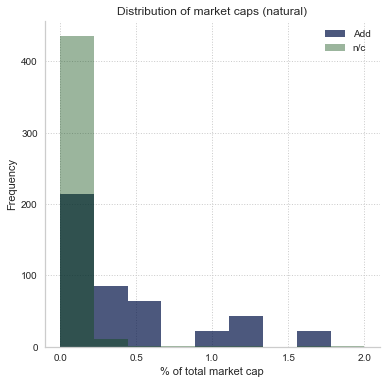

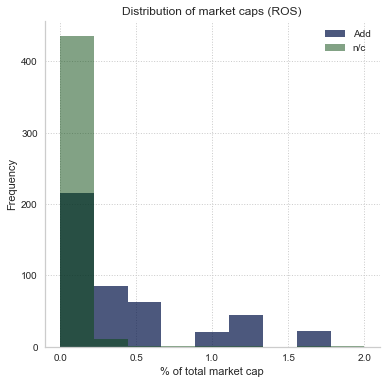

In [639]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.hist(X_train[:,0][y_train], density=True, bins=np.linspace(0,0.02,10), alpha=0.7, histtype='stepfilled', label='Add', color=['xkcd:navy blue'])
ax.hist(X_train[:,0][~y_train], density=True, bins=np.linspace(0,0.02,10), alpha=0.4, histtype='stepfilled', label='n/c', color=['xkcd:forest green'])
#plt.hist(y_train)
plt.title('Distribution of market caps (natural)')
plt.ylabel('Frequency')
plt.xlabel('% of total market cap')
plt.legend(frameon=False, loc='top right')
plt.xticks(np.linspace(0,0.02,5), np.linspace(0,2,5))
plt.show()

fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.hist(X_train_resample[:,0][y_train_resamle], density=True, bins=np.linspace(0,0.02,10), alpha=0.7, histtype='stepfilled', label='Add', color=['xkcd:navy blue'])
ax.hist(X_train_resample[:,0][~y_train_resamle], density=True, bins=np.linspace(0,0.02,10), alpha=0.5, histtype='stepfilled', label='n/c', color=['xkcd:forest green'])
#plt.hist(y_train)
plt.title('Distribution of market caps (ROS)')
plt.ylabel('Frequency')
plt.xlabel('% of total market cap')
plt.legend(frameon=False, loc='top right')
plt.xticks(np.linspace(0,0.02,5), np.linspace(0,2,5))

plt.show()

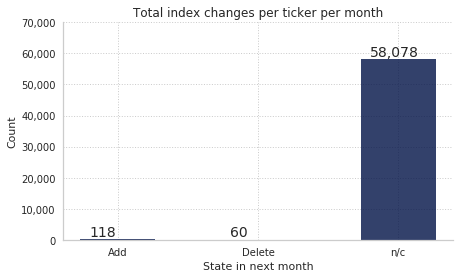

In [642]:
import matplotlib as mpl

font = {'family' : 'grg',
        'weight' : 'normal',
        'size'   : 14}


fig = plt.figure(figsize=(7,4))
plt.rc('font', **font)
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.bar(np.linspace(0,3,3), [filtered['add'].sum(),filtered['del'].sum(),filtered['add'].count()], alpha=0.8, color=['xkcd:navy blue'])
#plt.hist(y_train)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Total index changes per ticker per month')
plt.ylabel('Count')
plt.ylim(0,70000)
plt.xlabel('State in next month')
plt.legend(frameon=False, loc='top right')
plt.xticks(np.linspace(0,3,3), ['Add','Delete','n/c'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{x:,.0f}'.format(x=height), (p.get_x()+0.1, p.get_y() + height + 1000))

plt.show()

11616 46462
0.9331955922865014
              precision    recall  f1-score   support

       False       1.00      0.93      0.96     46365
        True       0.03      0.89      0.05        97

   micro avg       0.93      0.93      0.93     46462
   macro avg       0.51      0.91      0.51     46462
weighted avg       1.00      0.93      0.96     46462



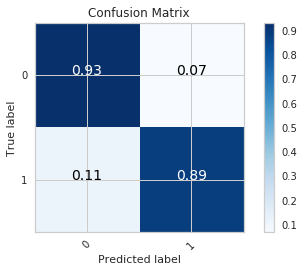

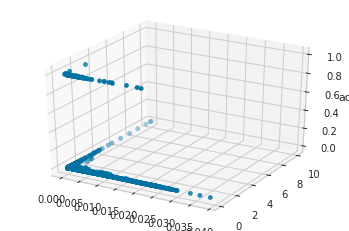

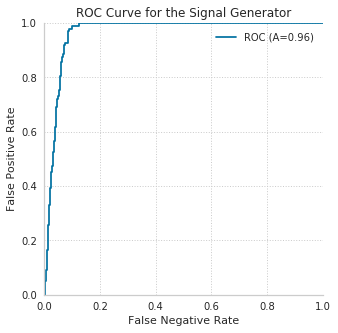

In [637]:
filtered['add']=filtered['action']=='Add'
filtered['del']=filtered['action']=='Delete'

from imblearn.over_sampling import SMOTE

SEED=0xDEADBEEF

y_col = 'add'
X_cols = ['pct_contrib','turnover','VWAP','vol','VWMC','SPTSXComp']
X = filtered[X_cols]
y = filtered[y_col]

X_test, X_train, y_test, y_train  = sk.model_selection.train_test_split(X.values, y.values, test_size=0.2, random_state=SEED)

sm = SMOTE(random_state=SEED)
ros = RandomOverSampler(random_state=SEED)
X_train_resample, y_train_resamle = ros.fit_resample(X_train, y_train)

print(len(X_train), len(X_test))

log_clf = LogisticRegression()
log_clf.fit(X_train_resample, y_train_resamle)

print(log_clf.score(X_train, y_train))

y_pred = log_clf.predict(X_test)
y_pred_prob = log_clf.predict_proba(X_test)
ml_utils.clf_model_eval(y_test, y_pred)
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
if len(X_cols)>1:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X.values[:,0],X.values[:,1],y.values)
    ax.set_zlabel(y_col)
else:
    ax = fig.add_subplot(111)
    ax.scatter(X.values, y.values)
    ax.set_xlabel(X_cols[0])
    ax.set_ylabel(y_col)
plt.show()

#from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
    
fig = plt.figure(figsize=(5,5))
fig.patch.set_facecolor('white')
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.grid(True,axis='both',linestyle=':')

ax.plot(fpr, tpr, label='ROC (A=%0.2f)' % roc_auc)
plt.legend(frameon=False, loc='best')

plt.title('ROC Curve for the Signal Generator')
plt.ylabel('False Positive Rate')
plt.xlabel('False Negative Rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [496]:
filtered.loc[filtered['del']].count()

ticker         60
month          60
vol            60
VWMC           60
VWAP           60
action         60
indexed        60
SPTSXComp      60
pct_contrib    60
float          60
turnover       60
add            60
del            60
dtype: int64

# Construct a portfolio

In [492]:
signals = filtered.copy(deep=True)
signals['prediction'] = log_clf.predict(X)
signals['probability'] = log_clf.predict_proba(X)[:,1]

signals = signals.loc[signals['prediction']]

signals['trade_date'] = signals['month'].apply(lambda month: (datetime.strptime(month, '%Y-%m')+timedelta(days=31)).replace(day=1))
signals = signals[['ticker','trade_date','probability']]

signals.to_sql('signals', conn, if_exists='replace', index=False)

In [488]:
holding_period = 20
look_back = 5

port_return = []

for i, signal in signals.iterrows():
    
    print('Buy %s (p=%f)' % (signal['ticker'], signal['probability']))
    
    look_back_to = signal['trade_date']-timedelta(days=look_back)
    
    # Choose the day to open the position on
    #  if the first day of the month is a weekend, find the next monday
    open_position_on = signal['trade_date']
    while open_position_on.strftime('%Y-%m-%d') not in returns['date'].values:
        open_position_on = open_position_on+timedelta(days=1)
    print(' > Open position on %s'%open_position_on.strftime('%Y-%m-%d'))
    
    close_position_on = signal['trade_date']+timedelta(days=holding_period)
    ss_return = returns.loc[(returns['ticker']==signal['ticker']) & (returns['datetime'].between(look_back_to, close_position_on))]
    
    # Choose the most appropriate abnormal return calculation
    rebal_dates = returns.loc[returns['ticker']==signal['ticker']]['rebal_date'].unique()
    try:
        rebal_date_to_use = datetime.strptime(max(rebal_dates)[:10],'%Y-%m-%d')
    except:
        print(' > No abnormal return data for %s; skipping' % signal['ticker'])
        continue
    for possible_date in rebal_dates:
        #print(possible_date)
        if signal['trade_date'] < datetime.strptime(possible_date[:10],'%Y-%m-%d'):
            rebal_date_to_use = possible_date
    ss_return = ss_return.loc[ss_return['rebal_date']==rebal_date_to_use]
    
    print(' > Using CAR calculations for %s' % str(rebal_date_to_use)[:10])
    
    # Remove things that might cause us trouble
    #ss_return.drop(['rebal_date','action'], axis=1, inplace=True)
    #ss_return = ss_return.drop_duplicates()
    
    ss_return['d'] = pd.to_datetime(ss_return['date']) - signal['trade_date']
    
    ss_return['culm_return'] = (ss_return['r_daily']+1).cumprod()
    ss_return['car'] = (ss_return['ar_daily']+1).cumprod()
    
    try:
        return_index = ss_return.loc[ss_return['datetime']==open_position_on].iloc[0]
    except:
        if str(open_position_on)[:10] < returns.loc[(returns['ticker']=='AEM')]['date'].min():
            print(' > Do not have market history to this date; skipping')
            continue
        else:
            print(' > Something went wrong')
            break
    
    for field in ['culm_return','car']:
        ss_return[field] = ss_return[field] - return_index[field]
        
    ss_return = ss_return[['ticker','date','d','culm_return', 'car']]
    ss_return['trade'] = i
    port_return.append(ss_return)
port_return = pd.concat(port_return)

#port_return

Buy AC (p=0.623648)
 > Open position on 2010-08-03
 > Using CAR calculations for 2010-12-20
Buy ACB (p=0.980830)
 > Open position on 2017-08-01
 > Using CAR calculations for 2018-03-19
Buy ACB (p=0.911580)
 > Open position on 2017-09-01
 > Using CAR calculations for 2018-03-19
Buy ACB (p=0.991649)
 > Open position on 2017-10-02
 > Using CAR calculations for 2018-03-19
Buy ACB (p=0.997842)
 > Open position on 2017-11-01
 > Using CAR calculations for 2018-03-19
Buy ACB (p=1.000000)
 > Open position on 2017-12-01
 > Using CAR calculations for 2018-03-19
Buy ACB (p=1.000000)
 > Open position on 2018-01-02
 > Using CAR calculations for 2018-03-19
Buy ACB (p=1.000000)
 > Open position on 2018-02-01
 > Using CAR calculations for 2018-03-19
Buy ACB (p=1.000000)
 > Open position on 2018-03-01
 > Using CAR calculations for 2018-03-19
Buy ACQ (p=0.571351)
 > Open position on 2014-04-01
 > Using CAR calculations for 2016-03-21
Buy ACQ (p=0.616853)
 > Open position on 2014-05-01
 > Using CAR calcul

In [491]:
returns.loc[(returns['ticker']=='AEM')]['date'].min()

'2010-01-04'

In [486]:
ml_tools

'2010-01-04'

In [439]:
returns['date'].values

array(['2010-03-01', '2010-03-02', '2010-03-03', ..., '2018-06-27',
       '2018-06-28', '2018-06-29'], dtype=object)